### 준비하기

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# font name을 알고 있다면 생략가능
#한글폰트 path 설정
font_path = 'C:\\windows\\Fonts\\malgun.ttf'
#font의 파일정보로 font name 을 알아내기
font_prop = fm.FontProperties(fname=font_path).get_name()
print(font_prop)

# matplotlib의 rc(run command) 함수를 사용해서 font name(Malgun Gothic) 설정
matplotlib.rc('font', family=font_prop)

Malgun Gothic


### 웹 크롤링(함수)

In [2]:
# 1. Selenium으로 데이터 크롤링
def scrap_kbo_rankings():
    # 크롬 드라이버 초기화
    driver = webdriver.Chrome()
    driver.get("https://www.koreabaseball.com/Record/TeamRank/TeamRankDaily.aspx")
    time.sleep(3)
    
    # 팀 데이터를 저장할 딕셔너리
    team_data = {}
    
    # 해당 테이블의 summary 값 (구분 기준)
    target_summary = "순위, 팀명,승,패,무,승률,승차,최근10경기,연속,홈,방문"

    # 필요한 날짜 범위만큼 반복 (예: 최근 5일 데이터)
    for _ in range(5):
        # print(f"\n=== {day + 1}번째 날짜 크롤링 시작 ===")  # 디버깅용 메시지
        # 날짜 추출
        date_element = driver.find_element(By.ID, "cphContents_cphContents_cphContents_lblSearchDateTitle")
        current_date = date_element.text.strip()
        # print(f"현재 날짜: {current_date}")  # 가져온 날짜 출력 (디버깅용)
        
        # summary 속성을 기준으로 테이블 선택
        table = None
        tables = driver.find_elements(By.TAG_NAME, "table")
        for tbl in tables:
            summary_attribute = tbl.get_attribute("summary")
            if summary_attribute == target_summary:
                table = tbl
                break
            
        # 테이블을 찾지 못한 경우
        if table is None:
            # print(f"'{target_summary}'를 가진 테이블을 찾지 못했습니다. 다음 날짜로 이동합니다.")
            continue
        
        
         # 테이블 행 데이터 가져오기
        rows = driver.find_elements(By.CSS_SELECTOR, 'tbody tr')
        # print(f"총 {len(rows)}개의 행이 발견되었습니다! (summary='{target_summary}')")

        for i, row in enumerate(rows):
            cols = row.find_elements(By.TAG_NAME, 'td')
            
            # 디버깅: 각 행의 모든 열 데이터 출력
            # print(f"행 {i + 1} 데이터: {[col.text.strip() for col in cols]}")

            # 데이터 행 필터링 (열이 부족하거나, 첫 번째 열이 숫자 형식이 아니면 스킵)
            if len(cols) < 2:
                # print(f"데이터가 부족한 행입니다. 건너뜁니다.")
                continue

            rank_text = cols[0].text.strip()  # 첫 번째 칸: 순위
            if not rank_text.isdigit():  # 숫자가 아니면 무시
                # print(f"순위 값이 숫자가 아닙니다: {rank_text}")
                continue

            # 정제된 데이터 추출
            rank = int(rank_text)
            team_name = cols[1].text.strip()  # 두 번째 칸: 팀 이름
            # print(f"  - 순위 {rank}: {team_name}")

            # 팀 데이터 저장
            if team_name not in team_data:
                team_data[team_name] = []
            
            team_data[team_name].append({"date": current_date, "rank": rank})

        # "이전 날짜" 버튼 클릭
        prev_date_button = driver.find_element(By.ID, "cphContents_cphContents_cphContents_btnPreDate")
        prev_date_button.click()
        # print("이전 날짜로 이동 중...")
        time.sleep(3)  # 데이터 로드 대기

    driver.quit()
    # print("\n크롤링 완료! 팀별 데이터를 딕셔너리에 저장했습니다.")
    
    # print("\n=== 수집된 데이터 일부 확인 ===")
    # for team, records in team_data.items():
    #     print(f"팀: {team}, 데이터: {records[:2]}")  # 각 팀의 첫 2개 데이터만 출력

    return team_data

### json으로 저장(함수)

In [3]:
# JSON 파일 저장 함수 정의
def save_to_json(data, filename="scrap_teamrank.json"):
    """
    딕셔너리를 JSON 파일로 저장하는 함수
    :param data: 저장할 데이터 (딕셔너리)
    :param filename: 생성할 JSON 파일 이름 (기본값: "scrap_teamrank.json")
    """
    try:
        save_folder = "../../csv"  # 현재 폴더 기준: jupyter/scraping → project/csv
        file_path = os.path.join(save_folder, filename)
        with open(file_path, "w", encoding="utf-8") as json_file:
            json.dump(data, json_file, indent=4, ensure_ascii=False)  # JSON 파일 생성
        print(f"\n데이터가 JSON 파일 '{filename}'로 저장되었습니다.")
    except Exception as e:
        print(f"\nJSON 파일 저장 중 오류 발생: {e}")

### json을 dataframe으로 변환(함수)

In [4]:
def load_data_from_json(json_data):
    """
    JSON 데이터를 Pandas DataFrame으로 변환.
    :param json_data: JSON 데이터 딕셔너리
    :return: 최근 -> 과거 순으로 정렬된 DataFrame
    """
    # JSON 데이터를 병합해 DataFrame으로 변환
    all_data = []
    for team, records in json_data.items():
        for record in records:
            record["team"] = team  # 팀 이름 추가
            all_data.append(record)
    
    # DataFrame 생성
    df = pd.DataFrame(all_data)
    
    # 날짜 변환 및 내림차순 정렬 (최근 -> 과거)
    df['date'] = pd.to_datetime(df['date'], format='%Y.%m.%d')  # 날짜 형식 변환
    df = df.sort_values(by=["date", "rank"], ascending=[False, True]).reset_index(drop=True)  # 내림차순으로 날짜 정렬
    
    return df

### 홈 일자별 팀 순위 시각화 하기(함수)

In [5]:
def plt_teamrank(df):
    """
    전체 팀 순위 변화를 날짜별로 시각화하며,
    범례는 최신 날짜 순위를 기준으로 정렬.
    """
    plt.figure(figsize=(15, 8))  # 그래프 크기 조정
    
    # 최신 날짜 기준으로 team 정렬
    most_recent_date = df['date'].max()  # 최신 날짜
    recent_data = df[df['date'] == most_recent_date]  # 최신 날짜 데이터 필터링
    sorted_teams = recent_data.sort_values(by='rank')['team'].tolist()  # 최신 순위로 팀 정렬
    
    # print(f"최신 날짜: {most_recent_date}")
    # print(f"범례 팀 순서: {sorted_teams}")
    
    # 팀별 데이터 플로팅
    for team in sorted_teams:  # 정렬된 팀 순서로 플로팅
        team_data = df[df['team'] == team].sort_values(by='date', ascending=False)  # 팀별 데이터 내림차순 정렬
        plt.plot(team_data['date'], team_data['rank'], marker='o', label=team)
    
    # 그래프 설정
    plt.gca().invert_yaxis()  # 순위 낮은 값이 위로 향하도록 반전
    # plt.xlabel("날짜", fontsize=12)
    plt.ylabel("순위", fontsize=12)
    plt.title("KBO 팀별 순위 변화", fontsize=16)
    plt.legend(
        title="팀",          # 범례 제목
        fontsize=10,         # 범례 글자 크기
        loc='upper left'    # 범례 위치: 오른쪽 아래
    )
    plt.yticks(range(1, 11))
    # plt.xticks(rotation=45)  # 날짜 각도 회전
    # 수직선 제거, 수평선만 유지
    plt.grid(axis='x', linestyle='')  # 수직선 제거
    plt.grid(axis='y', linestyle='-', alpha=0.7)  # 수평선 유지
    plt.show()

### 함수 호출하기

In [6]:
# scrap_kbo_rankings 함수를 실행하고, 결과를 변수에 저장
team_data = scrap_kbo_rankings()

# # 결과를 확인
# print(team_data)

In [7]:
save_to_json(team_data)


데이터가 JSON 파일 'scrap_teamrank.json'로 저장되었습니다.


In [8]:
# JSON 데이터 로드
with open("../../csv/scrap_teamrank.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

df = load_data_from_json(json_data)

# # 데이터 확인
# print(df.head())  # 상위 5개 출력 (최근 -> 과거 순)

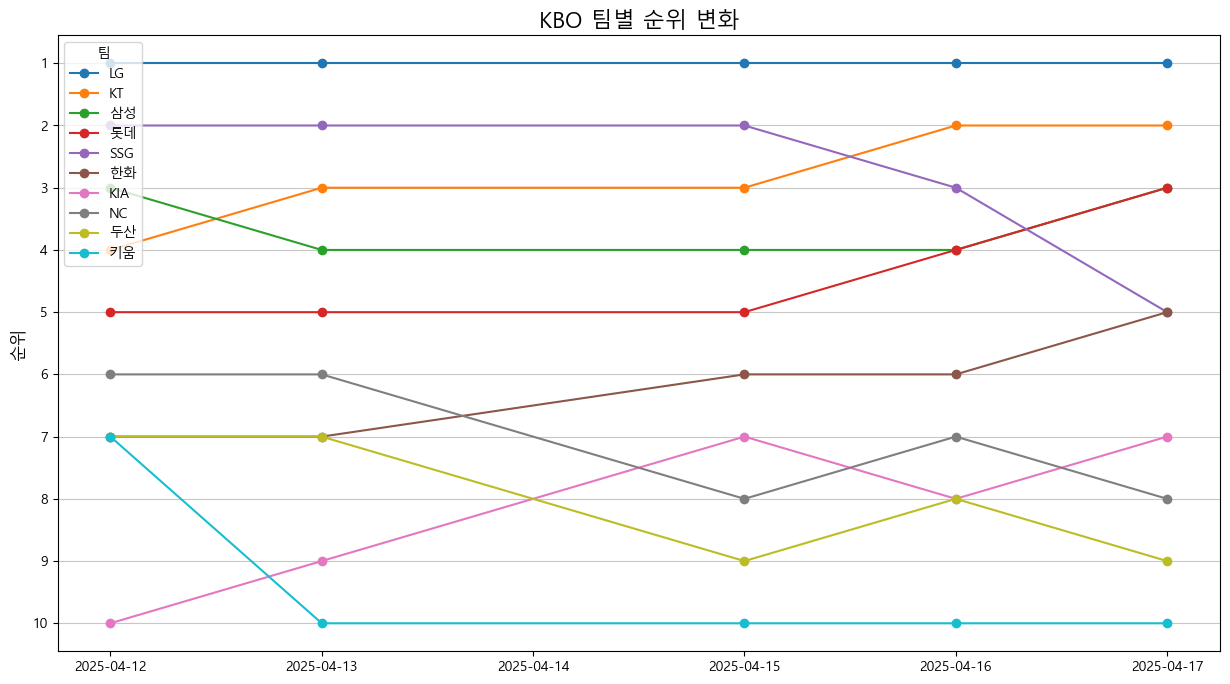

In [9]:
# 시각화 함수 호출
plt_teamrank(df)